In [37]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

import unicodedata
import re
import random
import time
import math

# hyperparameters

In [38]:
path = './'
resume_train = False
MAX_LENGTH = 10 	# max length of sentence
tfr = 0.5 			# teacher_forcing_ratio
hidden_size = 256
learning_rate = 0.01

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# helpers

In [40]:
def asMinutes(s):
	m = math.floor(s / 60)
	s -= m * 60
	return '%dm %ds' % (m, s)


def timeSince(since, percent):
	now = time.time()
	s = now - since
	es = s / percent
	rs = es - s
	return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
	fig, ax = plt.subplots()
	# this locator puts ticks at regular intervals
	loc = ticker.MultipleLocator(base=0.2)
	ax.yaxis.set_major_locator(loc)
	plt.plot(points)
	plt.show()

# data handling

In [41]:
SOS_token = 0
EOS_token = 1


class Lang:
	def __init__(self, name):
		self.name = name
		self.word2index = {}
		self.word2count = {}
		self.index2word = {0: "SOS", 1: "EOS"}
		self.n_words = 2 	# Count SOS and EOS

	def addSentence(self, sentence):
		for word in sentence.split(' '):
			self.addWord(word)

	def addWord(self, word):
		if word not in self.word2index:
			self.word2index[word] = self.n_words
			self.word2count[word] = 1
			self.index2word[self.n_words] = word
			self.n_words += 1
		else:
			self.word2count[word] += 1

### Turn a Unicode string to plain ASCII, 
thanks to https://stackoverflow.com/a/518232/2809427

In [42]:
def unicodeToAscii(s):
	return ''.join(
		c for c in unicodedata.normalize('NFD', s)
		if unicodedata.category(c) != 'Mn'
	)

### Lowercase, trim, and remove non-letter characters

In [43]:
def normalizeString(s):
	s = unicodeToAscii(s.lower().strip())
	s = re.sub(r"([.!?])", r" \1", s)
	s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
	return s

In [44]:
def readLangs(lang1, lang2, reverse=False):
	print("Reading lines...")

	# Read the file and split into lines
	lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
		read().strip().split('\n')

	# Split every line into pairs and normalize
	pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

	# Reverse pairs, make Lang instances
	if reverse:
		pairs = [list(reversed(p)) for p in pairs]
		input_lang = Lang(lang2)
		output_lang = Lang(lang1)
	else:
		input_lang = Lang(lang1)
		output_lang = Lang(lang2)

	return input_lang, output_lang, pairs

### trim the dataset to sentence with max. 10 words

In [45]:
eng_prefixes = (
	"i am ", "i m ",
	"he is", "he s ",
	"she is", "she s ",
	"you are", "you re ",
	"we are", "we re ",
	"they are","they re ")


def filterPair(p):
	return len(p[0].split(' ')) < MAX_LENGTH and \
		len(p[1].split(' ')) < MAX_LENGTH and \
		p[1].startswith(eng_prefixes)


def filterPairs(pairs):
	return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
	input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
	print('Read %s sentence pairs' % len(pairs))
	pairs = filterPairs(pairs)
	print('Trimmed to %s sentence pairs' % len(pairs))
	print('Counting words...')
	for pair in pairs:
		input_lang.addSentence(pair[0])
		output_lang.addSentence(pair[1])
	print('Counted words:')
	print(input_lang.name, input_lang.n_words)
	print(output_lang.name, output_lang.n_words)
	return input_lang, output_lang, pairs


def indicesFromSentence(lang, sentence):
	return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
	indices = indicesFromSentence(lang, sentence)
	indices.append(EOS_token)
	return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
	input_tensor = tensorFromSentence(input_lang, pair[0])
	target_tensor = tensorFromSentence(output_lang, pair[1])
	return (input_tensor, target_tensor)

# model

In [46]:
class EncoderRNN(nn.Module):
	def __init__(self, input_size, hidden_size):
		super(EncoderRNN, self).__init__()
		self.hidden_size = hidden_size

		self.embedding = nn.Embedding(input_size, hidden_size)
		self.gru = nn.GRU(hidden_size, hidden_size)

	def forward(self, input, hidden):
		embedded = self.embedding(input).view(1, 1, -1)
		output = embedded
		output, hidden = self.gru(output, hidden)
		return output, hidden

	def initHidden(self):
		return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
	def __init__(self, hidden_size, output_size):
		super(DecoderRNN, self).__init__()
		self.hidden_size = hidden_size

		self.embedding = nn.Embedding(output_size, hidden_size)
		self.gru = nn.GRU(hidden_size, hidden_size)
		self.out = nn.Linear(hidden_size, output_size)
		self.softmax = nn.LogSoftmax(dim=1)
		self.relu = nn.ReLU()

	def forward(self, input, hidden):
		output = self.embedding(input).view(1, 1, -1)
		output = self.relu(output)
		output, hidden = self.gru(output, hidden)
		output = self.softmax(self.out(output[0]))
		return output, hidden

	def initHidden(self):
		return torch.zeros(1, 1, self.hidden_size, device=device)


class Model(nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(Model, self).__init__()

		self.max_length = MAX_LENGTH
		self.hidden_size = hidden_size

		self.enc = EncoderRNN(input_size, hidden_size)
		self.dec = DecoderRNN(hidden_size, output_size)

	def forward(self, src_tensor, tar_tensor, criterion):
		# src_tensor n_src_words x 1, tar_tensor n_tar_words
		enc_hidden = self.enc.initHidden()

		# encoder loop; ignore encoder output
		for ei in range(src_tensor.size(0)):
			_, enc_hidden = self.enc(src_tensor[ei], enc_hidden)

		dec_input = torch.tensor([[SOS_token]], device=device)
		dec_hidden = enc_hidden		# instead of using initHidden()

		loss = 0
		if random.random() < tfr:
			# Teacher forcing: feed the target as the next input
			for di in range(tar_tensor.size(0)):
				dec_output, dec_hidden = self.dec(dec_input, dec_hidden)

				loss += criterion(dec_output, tar_tensor[di])
				dec_input = tar_tensor[di]	# Teacher forcing
		else:
			# without Teacher forcing: use its own predictions as the next input
			for di in range(tar_tensor.size(0)):
				dec_output, dec_hidden = self.dec(dec_input, dec_hidden)

				topv, topi = dec_output.topk(1)
				dec_input = topi.squeeze().detach() # detach from history as input

				loss += criterion(dec_output, tar_tensor[di])
				if dec_input.item() == EOS_token:
					break

		return loss

	def evaluate(self, sentence):
		src_tensor = tensorFromSentence(input_lang, sentence)

		# encoder
		enc_hidden = self.enc.initHidden()
		for ei in range(src_tensor.size(0)):
			enc_output, enc_hidden = self.enc(src_tensor[ei], enc_hidden)

		# decoder
		dec_input = torch.tensor([[SOS_token]], device=device)
		dec_hidden = enc_hidden

		decoded_words = []
		for di in range(self.max_length):
			dec_output, dec_hidden = self.dec(dec_input, dec_hidden)

			topv, topi = dec_output.topk(1)
			if topi.item() == EOS_token:
				decoded_words.append('<EOS>')
				break
			else:
				decoded_words.append(output_lang.index2word[topi.item()])

			dec_input = topi.squeeze().detach()

		return decoded_words

# train

In [47]:
def train(model, optimizer, criterion, n_iters, print_every=1000, plot_every=100):
	start = time.time()

	# create batch
	training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

	model.train()
	print_loss_total, plot_loss_total, plot_losses = 0, 0, []
	for iter in range(1, n_iters + 1):
		training_pair = training_pairs[iter - 1]
		src_tensor, tar_tensor = training_pair[0], training_pair[1]

		optimizer.zero_grad()
		loss = model(src_tensor.to(device), tar_tensor.to(device), criterion)
		loss.backward()
		optimizer.step()

		# print_loss_total += loss.item() / tar_tensor.size(0)
		plot_loss_total += loss.item() / tar_tensor.size(0)

		# if iter % print_every == 0:
		# 	print_loss_avg = print_loss_total / print_every
		# 	print_loss_total = 0
		# 	print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), 
		# 		iter, iter / n_iters * 100, print_loss_avg))

		# 	torch.save(model.state_dict(), path + 'model.pt')

		if iter % plot_every == 0:
			plot_loss_avg = plot_loss_total / plot_every
			plot_losses.append(plot_loss_avg)
			plot_loss_total = 0

	showPlot(plot_losses)

In [48]:
print(path)

./


# evaluate

In [49]:
def evaluate(model, n=10):
	model.eval()
	with torch.no_grad():
		for ii in range(n):
			pair = random.choice(pairs)
			print('>', pair[0])
			print('=', pair[1])
			output_words = model.evaluate(pair[0])
			output_sentence = ' '.join(output_words)
			print('<', output_sentence)
			print('')



### pre-process data, print a sample

In [50]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu es fort occupee .', 'you re very busy .']


### create model, optimizer, and criterion

4m 18s (- 60m 15s) (5000 6%) 2.9571
10m 15s (- 66m 42s) (10000 13%) 2.3864
16m 29s (- 65m 57s) (15000 20%) 2.0599
22m 45s (- 62m 35s) (20000 26%) 1.7863
29m 0s (- 58m 1s) (25000 33%) 1.5832
35m 17s (- 52m 55s) (30000 40%) 1.3873
41m 42s (- 47m 39s) (35000 46%) 1.2318
48m 9s (- 42m 8s) (40000 53%) 1.1296
53m 16s (- 35m 30s) (45000 60%) 0.9909
57m 18s (- 28m 39s) (50000 66%) 0.8836
61m 46s (- 22m 27s) (55000 73%) 0.7997
66m 17s (- 16m 34s) (60000 80%) 0.7109
70m 39s (- 10m 52s) (65000 86%) 0.6535
75m 2s (- 5m 21s) (70000 93%) 0.5741
79m 37s (- 0m 0s) (75000 100%) 0.4960


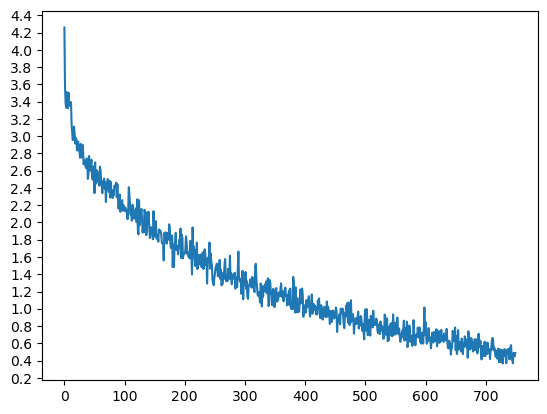

> nous sommes en ville .
= we re in town .
< we re in town . <EOS>

> je ne suis pas normal .
= i m not normal .
< i m not normal . <EOS>

> je ne le dirai pas deux fois .
= i m only going to say this once .
< i m only only going to this this . <EOS>

> je suis ravi d etre ici .
= i m delighted to be here .
< i m delighted to be here . <EOS>

> elle n a pas tort .
= she s got a point .
< she s not wrong . <EOS>

> il est nerveux d aller en amerique .
= he is anxious to go to america .
< he s eager to go to die . <EOS>

> je commence a la detester .
= i m beginning to hate her .
< i m beginning to hate . <EOS>

> je ne le fais plus .
= i m not doing it anymore .
< i m not doing this anymore . <EOS>

> il est negligent en matiere d argent .
= he is careless about money .
< he s short about money . <EOS>

> je ne gobe pas votre histoire .
= i m not buying your story .
< i m not your your story . <EOS>



In [54]:
model = Model(input_lang.n_words, hidden_size, output_lang.n_words).to(device)
resume_train = False
if resume_train:
	model.load_state_dict(torch.load(path + 'model.pt'))

	
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# train model
train(model, optimizer, criterion, 75000, print_every=5000, plot_every=100)

# evaluate model
evaluate(model)